# Stock Trades by Members of the US House of Representatives

This project uses public data about the stock trades made by members of the US House of Representatives. This data is collected and maintained by Timothy Carambat as part of the [House Stock Watcher](https://housestockwatcher.com/) project. The project describes itself as follows:

> With recent and ongoing investigations of incumbent congressional members being investigated for potentially violating the STOCK act. This website compiles this publicly available information in a format that is easier to digest then the original PDF source.
>
> Members of Congress must report periodic reports of their asset transactions. This website is purely for an informative purpose and aid in transparency.
>
> This site does not manipluate or censor any of the information from the original source. All data is transcribed by our community of contributors, which you can join for free by going to our transcription tool. Our moderation team takes great care in ensuring the accuracy of the information.
>
> This site is built and maintained by Timothy Carambat and supported with our contributors.

# Summary of Findings

### Introduction
For this project, we chose to analyze the stocks dataset, which most importantly includes the representative who made the transation, date, size (amount), stock (ticker), the type of transaction, and the district in which the representative is in. We decided to analyze the trades between the two dominant political parties, but the dataset does not contain the political alignment of each representative, so we merged another dataset containing the political affiliation to each transaction. After some initial analysis of the data, it appeared that republicans spend more per transaction than their respective democrats, so we ran a hypothesis test to test if republicans spent more on average per transaction than democrats.

### Cleaning and EDA
We were given a .csv file of stocks and transaction data recorded for each member of congress. We also found an online dataset of political affiliations of each congressman/political district they are part, and we merged this with the given stocks dataframe to add information about the political affiliations for each member of congress. Once we read in both these files, we had to clean each dataframe. For the “stocks” dataframe, we had to find strings representing null values and change them to NaN, we then changed the string dates to a Datetime type so we can plot time series graphs, and finally we converted the amounts column to lower-bounded integers and assigned them to groups in another column according to size of transaction. In the "districts" dataframe, we dropped all the irrelevant information besides the political party in 2018.

With both these dataframes finally cleaned, we were able to merge them on a left join on stocks to assign all possible party affiliations to the stocks dataframe. With this information all in one place, we were able to make valuable analyses on our data which helped us determine what question to answer in our hypothesis test. After finding aggregate statistics and plotting distrubutions of price groups and amounts, we wanted to further explore the relationship between democratic and republican transactions, so we plotted time series data in scatter plots and line charts to see if there were any interesting findings. We also created pivot tables with political party as the index and found statistics on the total expenditure and the number of transactions per party, and we found these statistics extremely relevant and interesting so we decided to base our hypothesis test on these.

### Assessment of Missingness
We immediately noticed that the 'owner' column had the most missing values, followed by the 'ticker' column. We began by running a missingness analysis on the owner column with the 'transaction_date' column. From initial observation, it appears that the oldest entires in the dataframe have missing values, while the newest entries are not null. We theorized that the missing data was simply not collected at the start, and it was included later at an arbitrary date. We used the difference of the mean dates between the missing values and non missing values as the test statistic, which is possible because we converted the dates into pandas datetime objects. The result is a difference of about 77 days, which is a strong indicator that the earlier days are more likely to have missing values. Sure enough, after running the permutation test by shuffling the owners column, we get a p-value of 0, which indicates that we can reject the null hypothesis that the missingness in owners is not related to the 'transaction_date' column. We concluded that the missingness type was MD (missing by design) because the data for owners was simply not collected at first, then was collected at a later time.

Now we wanted to find a column on which the missingness of 'owners' did not dependent on, so we tried the 'party' column, as it was appended to our dataframe based on the 'districts' column. Since the 'party' column contains categorical data ('D' or 'R'), we ran a permutation test with the TVD as the test statistic. However, this permutation test also returned a p-value of 0 unlike what we expected, so we concluded that there must have been a hidden confounding variable behind this result. One possible explanation could be that the proportion of transactions for one party was higher initially (when 'owners' was null), then after 'owners' were included, the other party recorded a higher frequency of transactions. Alternatively, our party column also had missing values which we ignored since the dataset containing parties that we merged did not contain all the districts on the stocks dataframe, which could have also impacted the result.

We continued to test if the missingness of 'owners' depended on the 'type' column since we believed that it would not be dependent. Similar to our previous test, we ran a permutation test with the TVD as the test statistic. However once again, we got a p-value of 0, meaning that there was a dependency on 'type' with 'owners'. This would make sense because since the missingness of 'owners' was so heavily time dependent, so the portion of the data with missing values and non missing values could represent different stages of the stock market cycle. While the market is following an uptrend, there would be more purchases than sales, and while the market is falling, the opposite would be true.

Furthermore, we tested the missingness of 'owners' against columns such as 'amount' or 'cap_gains_over_200_usd' (not included in the notebook since it was the same code to test 'transaction_date'), all with no luck of finding a column that was independent. If we look at the analysis graphs plotting the trade amounts over time, we see that the trade amounts increase over time, which could be due to a more volitile market or inflation if the numbers are not adjusted. Therefore, it would make sense for the p-value of these tests to also be 0, indicating some sort of dependency though it may be indirect.

Since the missingness of 'owners' was too heavily time dependent which would likely be correlated with other columns, we switched to test the missingness of 'ticker' against other columns. We tested for missingness of 'ticker' against party affiliation using the TVD of political parties as the test statistic, getting a p-value of about 0.025. Using a 1% confidence interval, we fail to reject the null that there is no dependency of party affiliation against the missingness of 'ticker.'

### Hypothesis Test
In our hypothesis test, we attempted to answer the question: Do republicans average more money per transaction than democrats?

After computing our observed statistic, we determined that the data shows that republicans average more money per transaction because the average amount per transaction for republicans is 36434 dollars while democrats average 26499 dollars. 

Based on these assumptions we labeled the following:

Null: There is no difference between republican and democrat average amount per transaction 

Alternate: Republicans average more money per transaction than democrats 

Test statistic: Total amount of money for republicans divided by the the total number of transaction made by republicans 

Simulation: Permutation test 

Significance Level: alpha=0.05

After running our test, we reach a p-value of 0.12, meaning that in 12% of our simulations had a value greater than or equal to our observed statistic. Since our p-value is greater than our established significance level of 0.05, we cannot reject the null hypothesis and therefore attribute seeing our observed statistic as due to chance. Our p-value is still small which shows that the probability of seeing our observed statistic is low, so it is possible that republicans average more money per transaction than democrats, but we still cannot reject the null. We ultimately conclude that there is no difference between the average amount per transaction between democrats and republicans.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [2]:
def cleaning_func(df):
    df=df.replace('--', np.NaN)
    df['disclosure_date'] = pd.to_datetime(df['disclosure_date'], errors='coerce')
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
    df['amount']= round(df['amount'].apply(lambda x: int(x.split()[0].strip('$').replace(',',''))),-1)
    df['price_grp'] = df['amount'].replace({1000:0, 15000:1, 50000:2, 100000:3, 250000:4, 500000:5, 1000000:6, 5000000:7, 50000000:8})
    df['district'] = df['district'].apply(lambda x: x[:2]+ x[2].strip('0')+x[3:])
    return df

In [3]:
df = pd.read_csv('data/all_transactions.csv')
stocks = cleaning_func(df)
stocks['amount'].value_counts()

1000        11243
15000        2541
50000         787
100000        594
250000        268
500000        162
1000000        82
5000000         9
50000000        1
Name: amount, dtype: int64

In [4]:
df2 = pd.read_csv('data/districts.csv')
districts = df2[['District', 'winning_party_2018']].rename(columns={'District':'district','winning_party_2018': 'party'})
districts

,district,party
0,AL1,R
1,AL2,R
2,AL3,R
3,AL4,R
4,AL5,R
...,...,...
430,WI5,R
431,WI6,R
432,WI7,R
433,WI8,R


In [5]:
#merged cleaned stocks data with polotical affiliation data
stocks = pd.merge(stocks, districts, on='district', how='left')
stocks

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,price_grp,party
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,1000,Hon. Virginia Foxx,NC5,https://disclosures-clerk.house.gov/public_dis...,False,0,R
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,1000,Hon. Virginia Foxx,NC5,https://disclosures-clerk.house.gov/public_dis...,False,0,R
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,15000,Hon. Virginia Foxx,NC5,https://disclosures-clerk.house.gov/public_dis...,False,1,R
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,15000,Hon. Virginia Foxx,NC5,https://disclosures-clerk.house.gov/public_dis...,False,1,R
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,1000,Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15682,2020,2020-06-10,2020-04-09,NaN,SWK,"Stanley Black & Decker, Inc.",sale_partial,1000,Hon. Ed Perlmutter,CO7,https://disclosures-clerk.house.gov/public_dis...,False,0,D
15683,2020,2020-06-10,2020-04-09,NaN,USB,U.S. Bancorp,sale_partial,1000,Hon. Ed Perlmutter,CO7,https://disclosures-clerk.house.gov/public_dis...,False,0,D
15684,2020,2020-06-10,2020-03-13,NaN,BMY,Bristol-Myers Squibb Company,sale_full,100000,Hon. Nicholas Van Taylor,TX3,https://disclosures-clerk.house.gov/public_dis...,False,3,R
15685,2020,2020-06-10,2020-03-13,NaN,LLY,Eli Lilly and Company,sale_full,500000,Hon. Nicholas Van Taylor,TX3,https://disclosures-clerk.house.gov/public_dis...,False,5,R


In [6]:
#gives us aggregate statistics on transactions per representative
stocks.groupby('representative')['amount'].agg(['mean', 'median', 'max', 'min', 'count']).sort_values(by='mean', ascending = False)

,mean,median,max,min,count
representative,,,,,
Hon. Michael Waltz,1382500.0,257500.0,5000000,15000,4
Mr. Scott Franklin,1000000.0,1000000.0,1000000,1000000,1
Hon. Adrian Smith,1000000.0,1000000.0,1000000,1000000,1
Hon. Doris O. Matsui,721937.5,1000000.0,1000000,1000,16
Hon. Jamie Raskin,625000.0,625000.0,1000000,250000,2
...,...,...,...,...,...
Hon. Sharice Davids,1000.0,1000.0,1000,1000,6
Hon. Stephanie Bice,1000.0,1000.0,1000,1000,1
Hon. Steve Chabot,1000.0,1000.0,1000,1000,2


In [7]:
#amount of transactions within each price group
stocks.groupby('price_grp')[['amount']].count()

,amount
price_grp,
0,11243
1,2541
2,787
3,594
4,268
5,162
6,82
7,9
8,1


<AxesSubplot:ylabel='Frequency'>

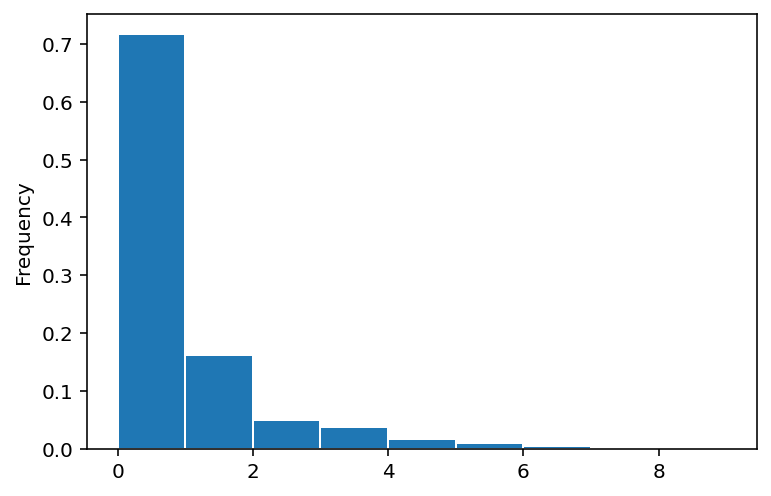

In [8]:
#histogram describing the frequency of transactions over all price groups
stocks['price_grp'].plot(kind = 'hist', bins= range(0,10), ec='w', density=True)

<AxesSubplot:xlabel='transaction_date', ylabel='price_grp'>

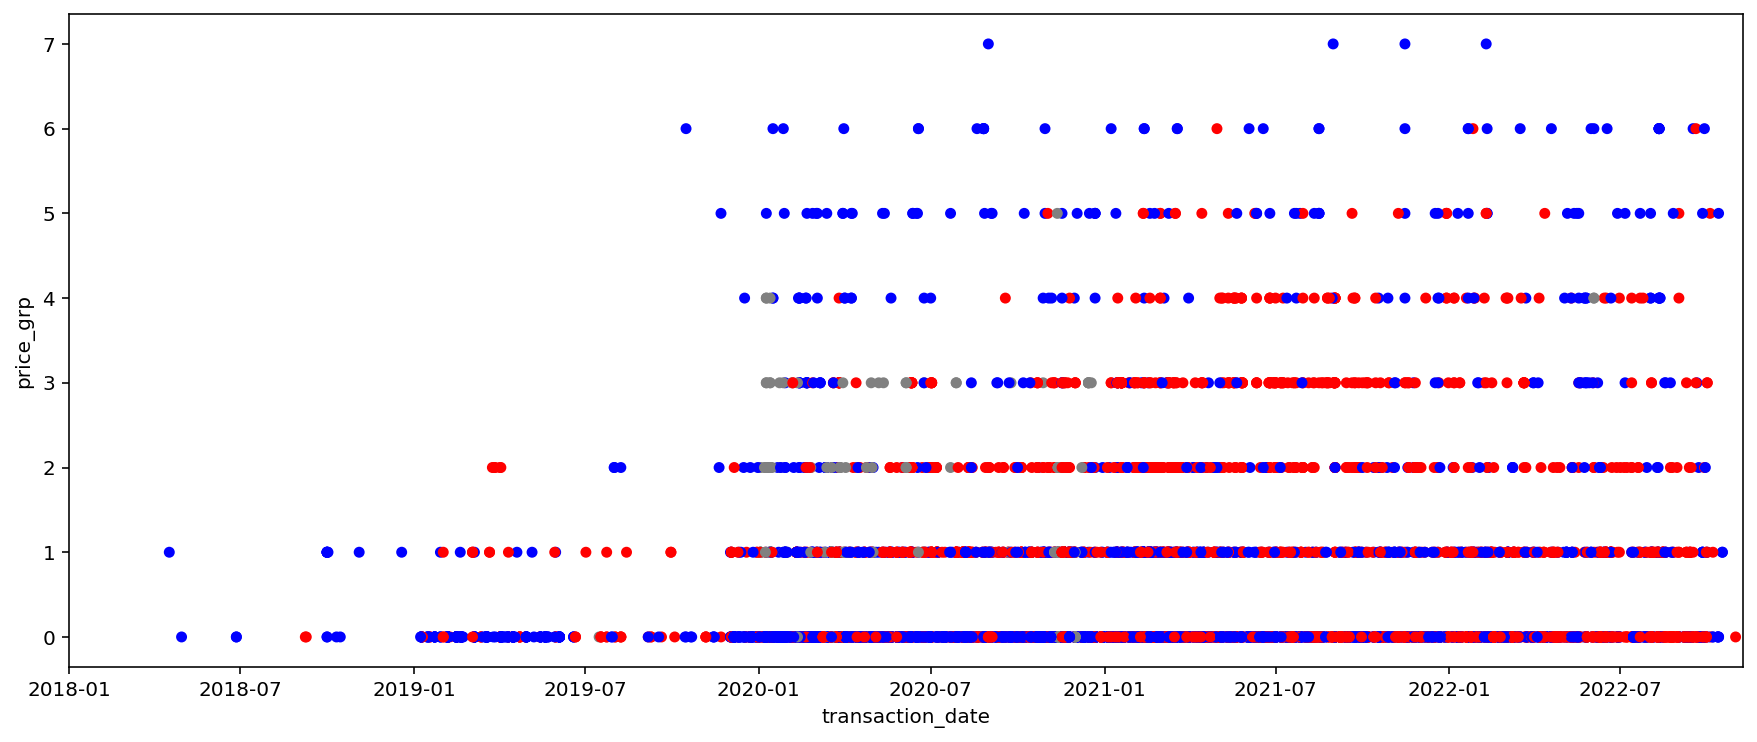

In [9]:
#graphing purchases over time with democrats in blue, republicans in red
colors = {'R': 'red', 'D': 'blue', np.NaN: 'grey'}
stocks[stocks['type'].str.contains('purchase')].plot(kind='scatter', x='transaction_date', y='price_grp', color= stocks[stocks['type'].str.contains('purchase')]['party'].map(colors), xlim=(pd.to_datetime('2018-01-01'),pd.to_datetime('2022-11-08')), figsize=(15,6))

<AxesSubplot:xlabel='transaction_date', ylabel='price_grp'>

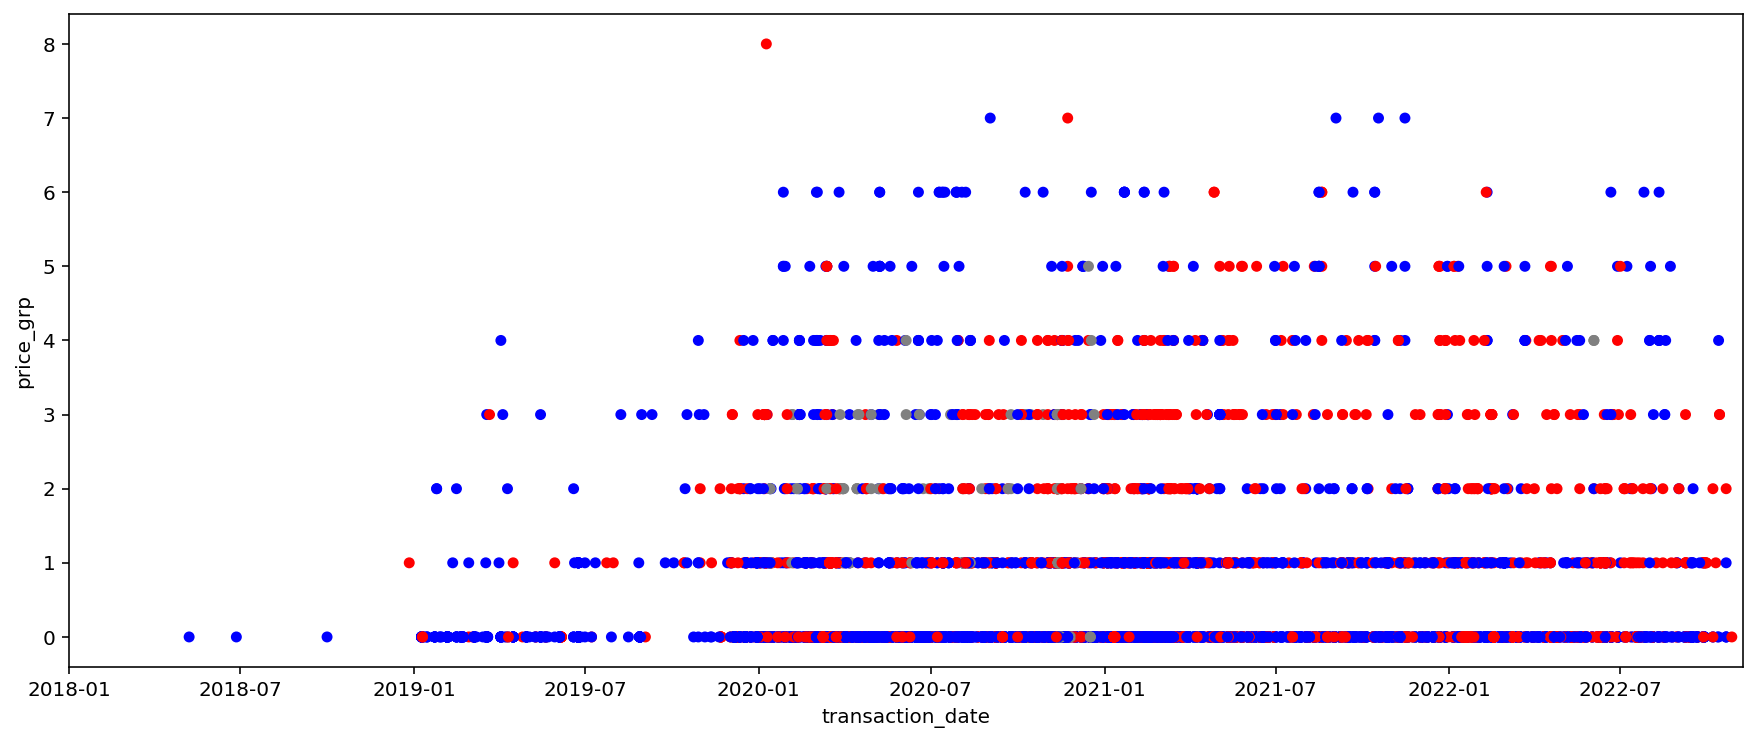

In [10]:
#graphing sales over time with democrats in blue, republicans in red
colors = {'R': 'red', 'D': 'blue', np.NaN: 'grey'}
stocks[stocks['type'].str.contains('sale')].plot(kind='scatter', x='transaction_date', y='price_grp', color= stocks[stocks['type'].str.contains('sale')]['party'].map(colors), xlim=(pd.to_datetime('2018-01-01'),pd.to_datetime('2022-11-08')), figsize=(15,6))

<AxesSubplot:xlabel='transaction_date', ylabel='price_grp'>

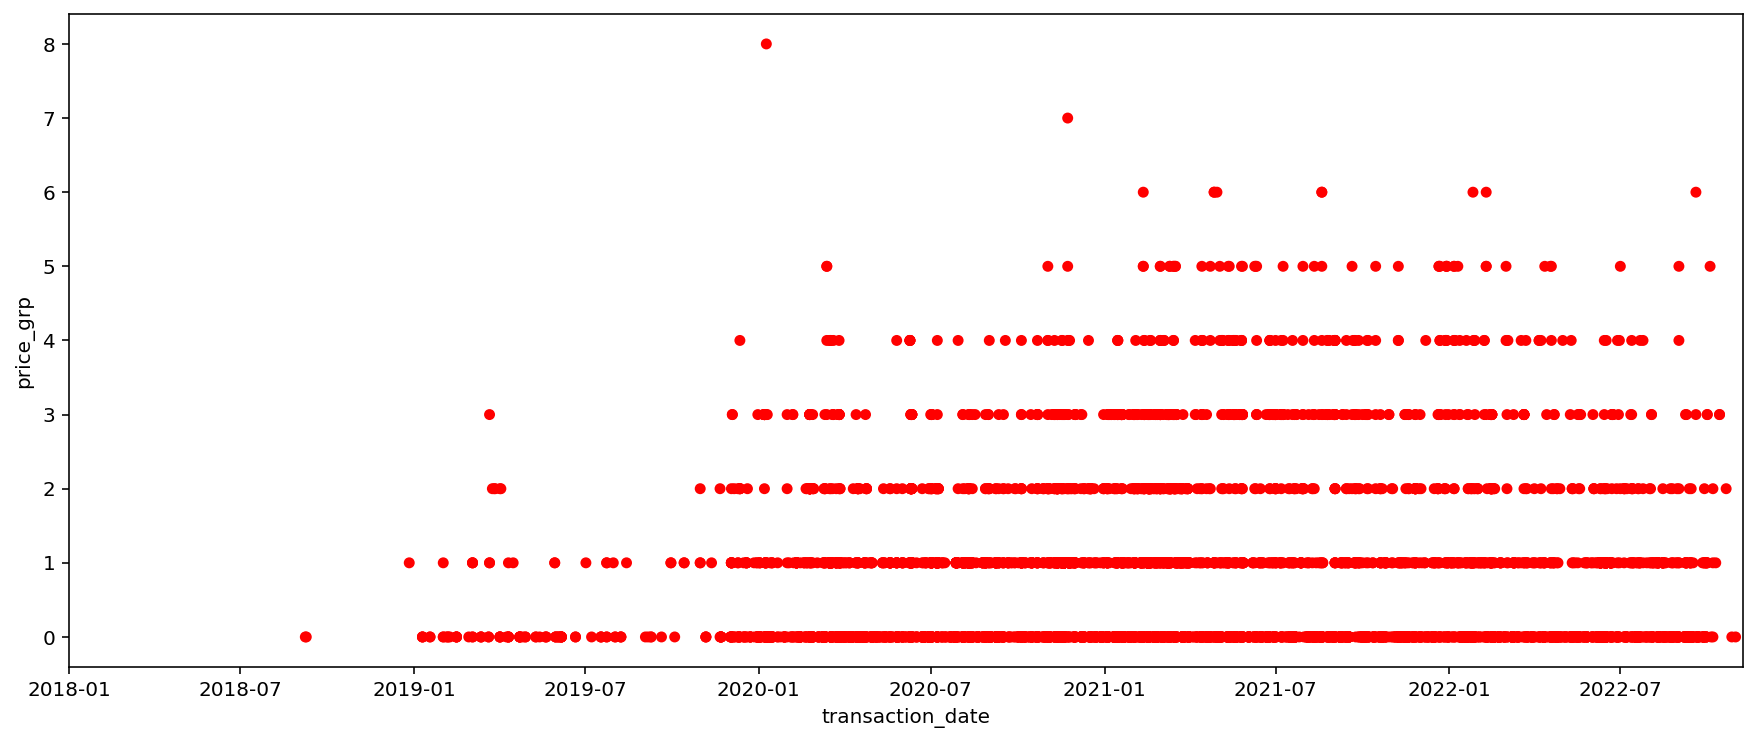

In [11]:
#graphing republican transactions over time
colors = {'R': 'red', 'D': 'blue', np.NaN: 'grey'}
stocks[stocks['party']=='R'].plot(kind='scatter', x='transaction_date', y='price_grp', color= stocks[stocks['party']=='R']['party'].map(colors), xlim=(pd.to_datetime('2018-01-01'),pd.to_datetime('2022-11-08')), figsize=(15,6))

<AxesSubplot:xlabel='transaction_date', ylabel='price_grp'>

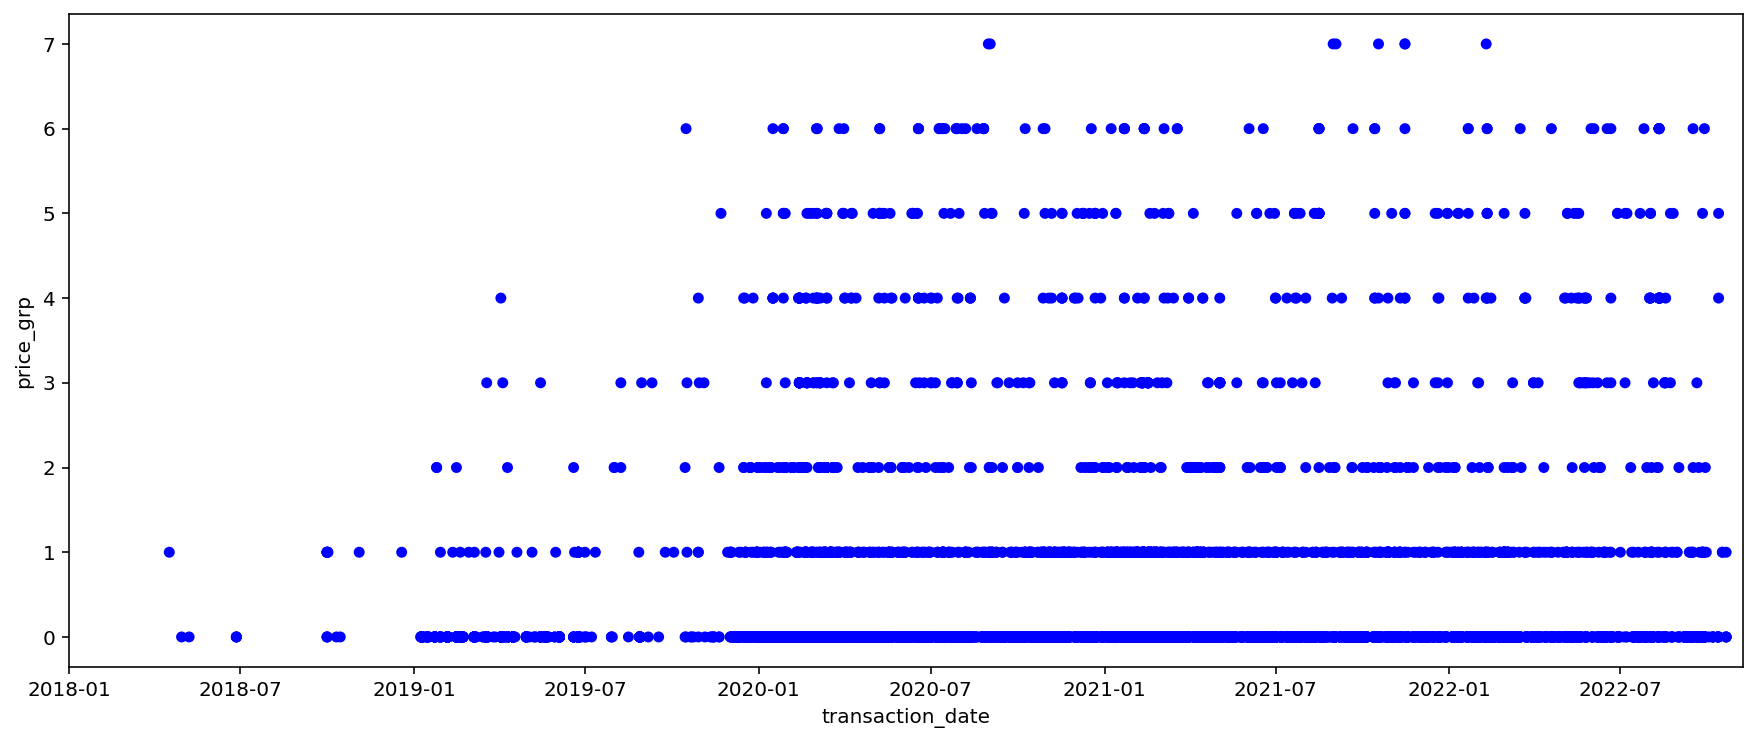

In [12]:
#graphing democrat transactions over time
colors = {'R': 'red', 'D': 'blue', np.NaN: 'grey'}
stocks[stocks['party']=='D'].plot(kind='scatter', x='transaction_date', y='price_grp', color= stocks[stocks['party']=='D']['party'].map(colors), xlim=(pd.to_datetime('2018-01-01'),pd.to_datetime('2022-11-08')), figsize=(15,6))

In [13]:
#approximate (lower bound) of total amount of money for each type of transaction per party
pd.pivot_table(stocks, index='party', columns='type', values='amount', aggfunc='sum')

type,exchange,purchase,sale,sale_full,sale_partial
party,,,,,
D,1414000.0,123632000.0,NaN,87386000.0,36871000.0
R,5436000.0,80462000.0,1000.0,119100000.0,3550000.0


In [14]:
#count of num transactions of each type per party
pd.pivot_table(stocks, index='party', columns='type', aggfunc='size')

type,exchange,purchase,sale,sale_full,sale_partial
party,,,,,
D,60.0,4504.0,NaN,3020.0,1824.0
R,79.0,3417.0,1.0,1826.0,401.0


In [15]:
#count of transactions per party
stocks.groupby('party').count()[['amount']]

,amount
party,
D,9408
R,5724


In [16]:
#count of transactions by type
stocks.groupby('type').count()[['amount']]

,amount
type,
exchange,139
purchase,8247
sale,1
sale_full,4942
sale_partial,2358


### Assessment of Missingness

In [17]:
#find a columns with missing values
stocks['owner'].isna().sum()

7336

In [18]:
#since owner column has missing values, now we can perform a permutation test with it against other columns. Lets try the transaction date first:
df = stocks.copy()
test_present = df[~df['owner'].isna()].get('transaction_date')
test_missing = df[df['owner'].isna()].get('transaction_date')
test_stat = abs(test_present.mean() - test_missing.mean())

#we will run a permutation test with the abs difference of mean dates as the test statistic
n_trials = 1000
diffs = []
for i in range(n_trials):
    df['owner'] = df['owner'].sample(frac = 1).reset_index(drop = True)
    present = df[~df['owner'].isna()].get('transaction_date')
    missing = df[df['owner'].isna()].get('transaction_date')
    stat = abs(present.mean() - missing.mean())
    diffs.append(stat)
#pval
(np.array(diffs) >= test_stat).mean()

0.0

In [19]:
#since the pvalue is 0, we can infer that the missinging is likely not due to randomness. 
#In fact, if we look closer, we notice that the oldest entires are NaN, but the most recent entries are not
#This could be because the information for the owner was not collected until a certain point in time, so it would be MD.

In [20]:
#Now lets try to test for missingness by choosing another column
df = stocks.copy()
test_rep_diff = abs((df[df['owner'].isna()].get('party') == 'R').mean() - (df[~df['owner'].isna()].get('party') == 'R').mean())
test_dem_diff = abs((df[df['owner'].isna()].get('party') == 'D').mean() - (df[~df['owner'].isna()].get('party') == 'D').mean())
test_tvd = (test_rep_diff + test_dem_diff) / 2

#we will run a permutation test with the TVD of political parties as the test statistic
n_trials = 1000
tvds = []
for i in range(n_trials):
    df['owner'] = df['owner'].sample(frac = 1).reset_index(drop = True)
    rep_diff = abs((df[df['owner'].isna()].get('party') == 'R').mean() - (df[~df['owner'].isna()].get('party') == 'R').mean())
    dem_diff = abs((df[df['owner'].isna()].get('party') == 'D').mean() - (df[~df['owner'].isna()].get('party') == 'D').mean())
    tvd = (rep_diff + dem_diff) / 2
    tvds.append(tvd)
#pval
(np.array(tvds) >= test_tvd).mean()

0.0

In [21]:
tvds[:5]

[0.0059128654885230725,
 0.007833317032014231,
 0.001478087827850777,
 0.01943709488556014,
 0.001478087827850777]

In [22]:
#We notice once again that our pvalue is 0; this could either be because there is a relationship of missingness
#between party and owner, or it could be due to the missing values in party itself, which could skew the results as well.

In [23]:
#Finally, we can try to test the missingness between type and owner
df = stocks.copy()
test_pur_diff = abs((df[df['owner'].isna()].get('type') == 'purchase').mean() - (df[~df['owner'].isna()].get('type') == 'purchase').mean())
test_salf_diff = abs((df[df['owner'].isna()].get('type') == 'sale_full').mean() - (df[~df['owner'].isna()].get('type') == 'sale_full').mean())
test_salp_diff = abs((df[df['owner'].isna()].get('type') == 'sale_partial').mean() - (df[~df['owner'].isna()].get('type') == 'sale_partial').mean())
test_ex_diff = abs((df[df['owner'].isna()].get('type') == 'exchange').mean() - (df[~df['owner'].isna()].get('type') == 'exchange').mean())
test_tvd = (test_pur_diff + test_salf_diff + test_salp_diff + test_ex_diff) / 2

#we will run a permutation test with the TVD of sale types as the test statistic
n_trials = 1000
tvds = []
for i in range(n_trials):
    df['owner'] = df['owner'].sample(frac = 1).reset_index(drop = True)
    pur_diff = abs((df[df['owner'].isna()].get('type') == 'purchase').mean() - (df[~df['owner'].isna()].get('type') == 'purchase').mean())
    salf_diff = abs((df[df['owner'].isna()].get('type') == 'sale_full').mean() - (df[~df['owner'].isna()].get('type') == 'sale_full').mean())
    salp_diff = abs((df[df['owner'].isna()].get('type') == 'sale_partial').mean() - (df[~df['owner'].isna()].get('type') == 'sale_partial').mean())
    ex_diff = abs((df[df['owner'].isna()].get('type') == 'exchange').mean() - (df[~df['owner'].isna()].get('type') == 'exchange').mean())
    tvd = (pur_diff + salf_diff + salp_diff + ex_diff) / 2
    tvds.append(tvd)
#pval
(np.array(tvds) >= test_tvd).mean()

0.0

In [24]:
#We cannot find any column for which the missingness of owner is not dependent on, likely due to the design of the data.

In [25]:
#Now lets try to test for missingness of ticker against party affiliation
df = stocks.copy()
test_rep_diff = abs((df[df['ticker'].isna()].get('party') == 'R').mean() - (df[~df['ticker'].isna()].get('party') == 'R').mean())
test_dem_diff = abs((df[df['ticker'].isna()].get('party') == 'D').mean() - (df[~df['ticker'].isna()].get('party') == 'D').mean())
test_tvd = (test_rep_diff + test_dem_diff) / 2

#we will run a permutation test with the TVD of political parties as the test statistic
n_trials = 1000
tvds = []
for i in range(n_trials):
    df['ticker'] = df['ticker'].sample(frac = 1).reset_index(drop = True)
    rep_diff = abs((df[df['ticker'].isna()].get('party') == 'R').mean() - (df[~df['ticker'].isna()].get('party') == 'R').mean())
    dem_diff = abs((df[df['ticker'].isna()].get('party') == 'D').mean() - (df[~df['ticker'].isna()].get('party') == 'D').mean())
    tvd = (rep_diff + dem_diff) / 2
    tvds.append(tvd)
#pval
(np.array(tvds) >= test_tvd).mean()

0.021

In [26]:
#We get a pvalue of about 0.025
#If we use a significance level of 0.01, we fail to reject the null hypothesis

### Hypothesis Test / Permutation Test

In [27]:
#Do republicans average more money per transaction than democrats?

In [28]:
#Compute observed statistic
total_amount = pd.pivot_table(stocks, index='party', columns='type', values='amount', aggfunc='sum').sum(axis=1)
num_trans = stocks.groupby('party').count()['amount']
obs_vals = (total_amount/num_trans)
obs_vals

party
D    26499.043367
R    36434.136967
dtype: float64

In [29]:
#Republicans average $36434 per transaction while Democrats average $26499
#Null: There is no difference between republican and democrat average amount per transaction 
#Alternate: Republicans average more money per transaction than democrats 
#Test statistic: Total amount of money for republicans divided by the the total number of transaction made by republicans 
#Simulation: Permutation test 
#Significance Level: alpha=0.05

In [30]:
obs_stat = (total_amount/num_trans).loc['R']
obs_stat

36434.136967155835

In [31]:
#Run simulation
test_stats = []
stocks2 = stocks.copy()
for i in range(1000):
    stocks2['party'] = stocks2['party'].sample(frac=1).reset_index(drop=True)
    total_amount = pd.pivot_table(stocks2, index='party', columns='type', values='amount', aggfunc='sum').sum(axis=1)
    num_trans = stocks2.groupby('party').count()['amount']
    test_stats.append((total_amount/num_trans).loc['R'])
    
test_stats = np.array(test_stats)

#P-value
(test_stats >= obs_stat).mean()

0.13

In [32]:
#We fail to reject the null since the p-value is not below our significance level
#The difference we observe could be due to chance alone